In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from moscot.problems.time import TemporalProblem
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scanpy as sc

In [5]:
adata = sc.read("/home/dominikk/data/pancreas_2022_reduced.h5ad")

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


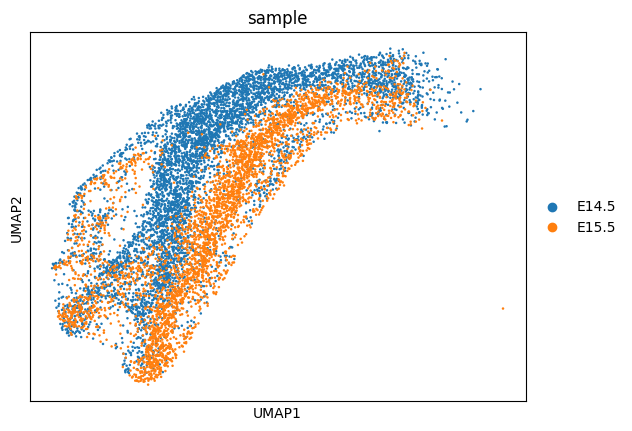

In [6]:
sc.pl.umap(adata, color="sample")

In [7]:
sc.pp.pca(adata, n_comps=10)

In [8]:
source = adata[adata.obs["sample"]=="E14.5"].obsm["X_pca"].copy()
target = adata[adata.obs["sample"]=="E15.5"].obsm["X_pca"].copy()

In [9]:
source.shape

(5458, 10)

In [10]:
adata.obs["day"] = adata.obs.apply(lambda x: 14.5 if x["sample"]=="E14.5" else 15.5, axis=1)
tp = TemporalProblem(adata)
tp = tp.prepare(time_key="day", joint_attr="X_pca")

In [11]:
tp = tp.solve(epsilon=1e-3, scale_cost="mean", max_iterations=1e7)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5458, 3768)].                                  


# Check the variances

In [12]:
adata_early = adata[adata.obs["sample"]=="E14.5"]
adata_late = adata[adata.obs["sample"]=="E15.5"]

## Check variances on source

In [13]:
from entot.metrics.metrics import compute_statistics_from_samples, sample_velocities_from_transport_matrix

2023-06-19 13:34:21.253962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
samples = sample_velocities_from_transport_matrix(tp[14.5, 15.5].solution.transport_matrix, target, 100)
res = compute_statistics_from_samples(samples, 10, adata_early.obs_names)

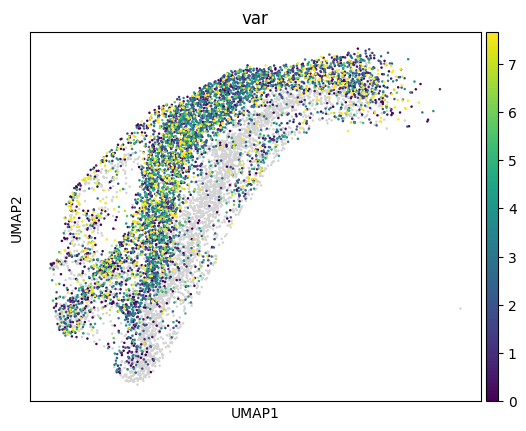

In [27]:
adata.obs["var"] = res["mean_of_variance"]
sc.pl.umap(adata, color="var", vmax="p90")

In [15]:
adata_early.obs = adata_early.obs.merge(res, how="left", left_index=True, right_index=True)

In [16]:
df_vars =adata_early.obs[["celltype", "var_of_variance", "mean_of_variance"]].groupby("celltype").mean()

In [17]:
order_celltypes = ["Alpha", "Beta", "Delta", "Epsilon", "Fev+ Alpha", "Fev+ Beta", "Fev+ Delta", "Fev+", "Eps. progenitors", "Ngn3 high", "Ngn3 low"]
df_vars = df_vars.reindex(order_celltypes)

In [18]:
df_vars

,var_of_variance,mean_of_variance
celltype,,
Alpha,1.817825,3.144765
Beta,0.547632,1.726651
Delta,1.904336,3.034451
Epsilon,6.320921,5.174164
Fev+ Alpha,2.182578,3.410730
Fev+ Beta,1.173598,2.639871
Fev+ Delta,3.837725,4.649381
Fev+,2.212731,3.261652
Eps. progenitors,3.323307,3.918227


/tmp/ipykernel_750781/2753713755.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(df_vars.index, rotation = 90)
/tmp/ipykernel_750781/2753713755.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(df_vars.index, rotation = 90)


[Text(0, 0, 'Alpha'),
 Text(1, 0, 'Beta'),
 Text(2, 0, 'Delta'),
 Text(3, 0, 'Epsilon'),
 Text(4, 0, 'Fev+ Alpha'),
 Text(5, 0, 'Fev+ Beta'),
 Text(6, 0, 'Fev+ Delta'),
 Text(7, 0, 'Fev+'),
 Text(8, 0, 'Eps. progenitors'),
 Text(9, 0, 'Ngn3 high'),
 Text(10, 0, 'Ngn3 low')]

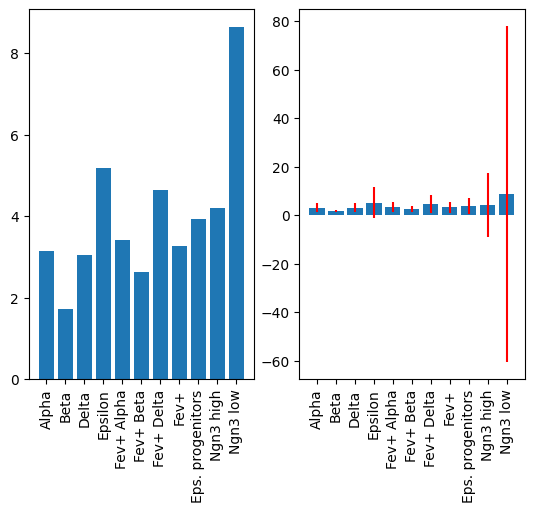

In [21]:
fig, axes = plt.subplots(1, 2)

axes[0].bar(df_vars.index, df_vars["mean_of_variance"], error_kw=dict(ecolor='r'))
axes[0].set_xticklabels(df_vars.index, rotation = 90)

axes[1].bar(df_vars.index, df_vars["mean_of_variance"], yerr=df_vars["var_of_variance"], error_kw=dict(ecolor='r'))
axes[1].set_xticklabels(df_vars.index, rotation = 90)

### Directional uncertainty

In [22]:
from entot.metrics.metrics import compute_directional_statistics_from_samples

In [34]:
df_dir, _ = compute_directional_statistics_from_samples(samples, 1, adata_early.obs_names)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5458 out of 5458 | elapsed:   30.3s finished


In [39]:
df_dir["celltype"] = adata_early.obs["celltype"]

In [50]:
adata.obs["directional_variance"] = df_dir["directional_variance"]
adata.obs["directional_difference"] = df_dir["directional_difference"]
adata.obs["directional_cosine_sim_variance"] = df_dir["directional_cosine_sim_variance"]

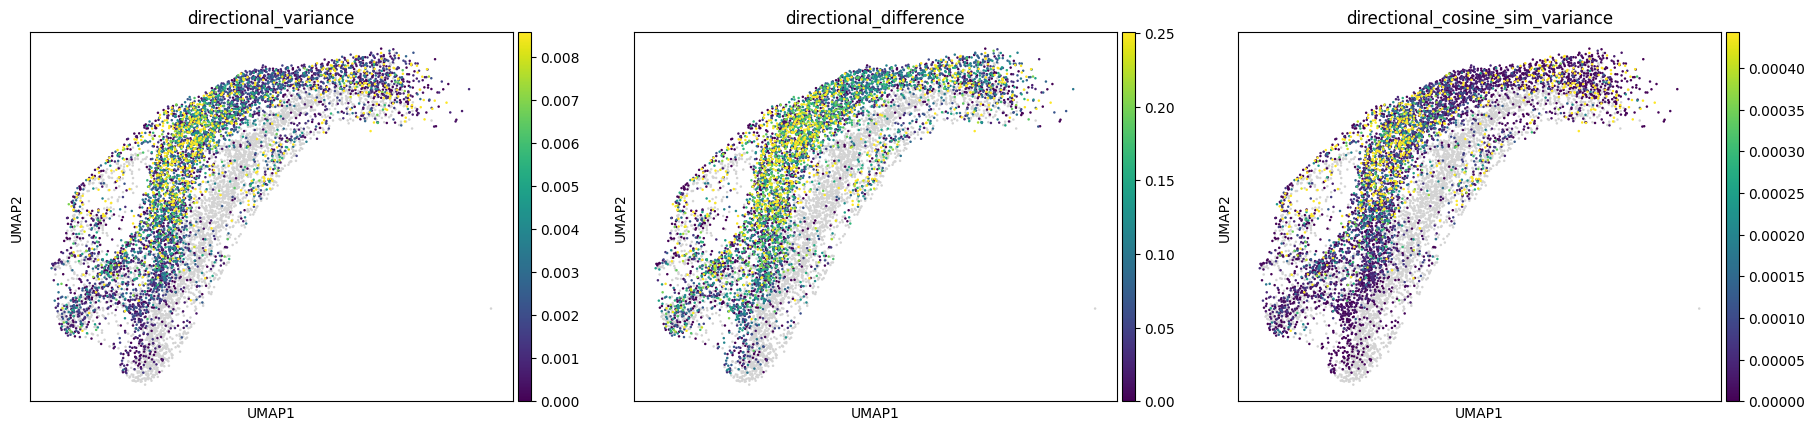

In [51]:
sc.pl.umap(adata, color=["directional_variance", "directional_difference", "directional_cosine_sim_variance"], vmax="p90")

In [41]:
df_vars =df_dir[["celltype", "directional_variance", "directional_difference", "directional_cosine_sim_mean", "directional_cosine_sim_variance"]].groupby("celltype").mean()

In [42]:
order_celltypes = ["Alpha", "Beta", "Delta", "Epsilon", "Fev+ Alpha", "Fev+ Beta", "Fev+ Delta", "Fev+", "Eps. progenitors", "Ngn3 high", "Ngn3 low"]
df_vars = df_vars.reindex(order_celltypes)

In [43]:
df_vars

,directional_variance,directional_difference,directional_cosine_sim_mean,directional_cosine_sim_variance
celltype,,,,
Alpha,0.001764,0.077913,0.994632,0.000045
Beta,0.000651,0.049676,0.997984,0.000006
Delta,0.001615,0.066244,0.994657,0.000050
Epsilon,0.003915,0.101875,0.988526,0.000281
Fev+ Alpha,0.002688,0.100479,0.992957,0.000091
Fev+ Beta,0.001541,0.077164,0.995520,0.000035
Fev+ Delta,0.004035,0.098983,0.988393,0.000344
Fev+,0.003033,0.110069,0.991839,0.000125
Eps. progenitors,0.004533,0.110845,0.987865,0.000352


/tmp/ipykernel_750781/3138520223.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(df_vars.index, rotation = 90)
/tmp/ipykernel_750781/3138520223.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(df_vars.index, rotation = 90)
/tmp/ipykernel_750781/3138520223.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(df_vars.index, rotation = 90)


[Text(0, 0, 'Alpha'),
 Text(1, 0, 'Beta'),
 Text(2, 0, 'Delta'),
 Text(3, 0, 'Epsilon'),
 Text(4, 0, 'Fev+ Alpha'),
 Text(5, 0, 'Fev+ Beta'),
 Text(6, 0, 'Fev+ Delta'),
 Text(7, 0, 'Fev+'),
 Text(8, 0, 'Eps. progenitors'),
 Text(9, 0, 'Ngn3 high'),
 Text(10, 0, 'Ngn3 low')]

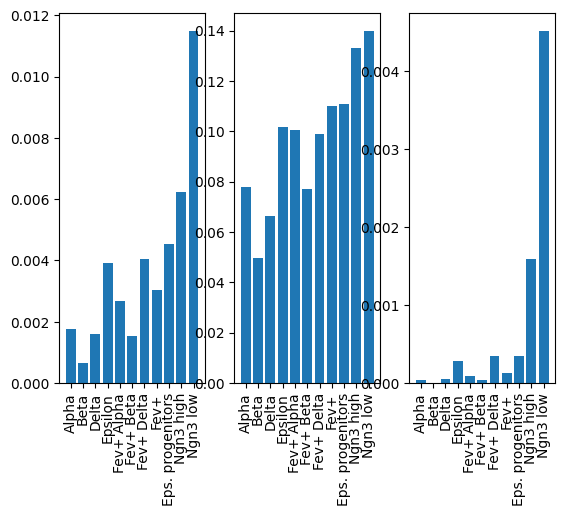

In [49]:
fig, axes = plt.subplots(1, 3)

axes[0].bar(df_vars.index, df_vars["directional_variance"], error_kw=dict(ecolor='r'))
axes[0].set_xticklabels(df_vars.index, rotation = 90)

axes[1].bar(df_vars.index, df_vars["directional_difference"], error_kw=dict(ecolor='r'))
axes[1].set_xticklabels(df_vars.index, rotation = 90)

axes[2].bar(df_vars.index, df_vars["directional_cosine_sim_variance"], error_kw=dict(ecolor='r'))
axes[2].set_xticklabels(df_vars.index, rotation = 90)

# Check accuracy of the model

In [75]:
cell_transition = tp.cell_transition(14.5, 15.5, {"celltype": order_celltypes}, {"celltype": order_celltypes}, forward=True)
cell_transition

,Alpha,Beta,Delta,Epsilon,Fev+ Alpha,Fev+ Beta,Fev+ Delta,Fev+,Eps. progenitors,Ngn3 high,Ngn3 high cycling,Ngn3 low
Alpha,7.874384e-01,0.172229,0.006229,0.009106,2.186746e-02,3.129665e-03,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
Beta,1.864140e-19,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
Delta,1.779200e-05,0.794240,0.074124,0.020575,1.652873e-02,9.451435e-02,2.833238e-19,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
Epsilon,1.481241e-01,0.038743,0.053459,0.673634,2.797443e-02,9.972148e-30,5.806503e-02,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
Fev+ Alpha,2.324887e-01,0.090029,0.003937,0.005904,4.668436e-01,1.963201e-01,4.477686e-03,2.167986e-32,0.000000,0.000000e+00,0.000000,0.000000
Fev+ Beta,6.439176e-03,0.603044,0.000826,0.000000,2.849241e-02,3.611988e-01,0.000000e+00,2.328397e-41,0.000000,0.000000e+00,0.000000,0.000000
Fev+ Delta,9.144909e-02,0.088506,0.100363,0.198729,1.015991e-01,9.508442e-02,2.720119e-01,4.061536e-02,0.006047,5.594492e-03,0.000000,0.000000
Fev+,5.140089e-03,0.019455,0.001486,0.001729,1.194420e-01,4.606853e-01,5.891029e-03,3.842608e-01,0.000000,9.109381e-12,0.001911,0.000000
Eps. progenitors,5.325864e-26,0.047451,0.016099,0.293944,1.324622e-08,2.459288e-03,2.476479e-01,1.260200e-02,0.283100,9.669744e-02,0.000000,0.000000
Ngn3 high,1.574315e-03,0.030442,0.002565,0.003715,3.609466e-03,2.519268e-02,8.767352e-03,1.549818e-01,0.035644,7.235400e-01,0.005880,0.004089


<Axes: >

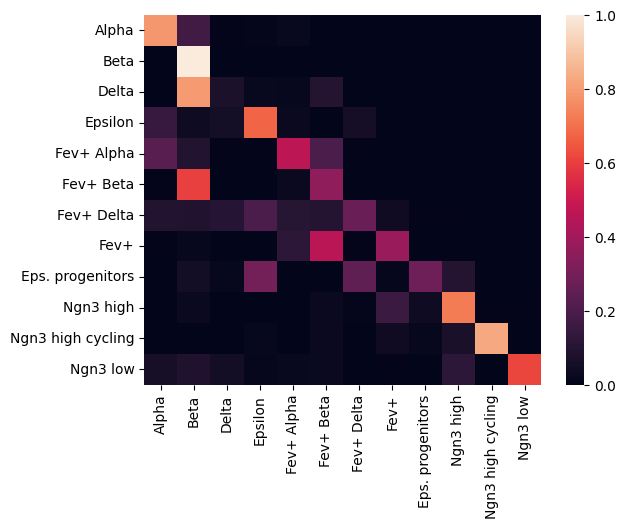

In [76]:
import seaborn as sns
sns.heatmap(cell_transition)